# 🏍️ Motorcycle Night Ride - 안전 점수 산출 프로젝트

## 프로젝트 개요
- **데이터셋**: Acme AI Open Dataset - Motorcycle Night Ride (야간 오토바이 주행, 200프레임)
- **목표**: 세만틱 세그멘테이션 데이터를 활용하여 프레임별 **안전 점수(Safety Score)** 산출
- **6개 클래스**: Undrivable, Road, Lanemark, My bike, Rider, Movable
- **방법론**: 규칙 기반 점수 설계 → ML 모델을 통한 안전 등급 분류

### 평가 기준
1. 데이터 EDA와 전처리가 적절하게 이뤄졌는가?
2. Task에 알맞는 적절한 모델을 선정했는가?
3. 성능 향상을 위해 논리적으로 접근했는가?
4. 결과 도출을 위해 여러 가지 시도를 진행했는가?
5. 도출된 결론에 충분한 설득력이 있는가?
6. 적절한 metric을 설정하고 그 사용 근거 및 결과를 분석하였는가?


In [1]:
# ============================================================
# 라이브러리 임포트
# ============================================================
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image
from collections import Counter, defaultdict
from pathlib import Path

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ 라이브러리 임포트 완료')


✅ 라이브러리 임포트 완료


---
# 1. 데이터 EDA (탐색적 데이터 분석)

데이터셋의 구조를 파악하고, 이미지와 세그멘테이션 마스크의 특성을 분석합니다.
- COCO JSON 구조 탐색 (images, annotations, categories)
- 이미지 파일 분류 (원본 / fuse / mask)
- 클래스별 분포 분석


In [17]:
# ============================================================
# 1-1. 데이터 경로 설정 및 파일 구조 탐색
# ============================================================
# DATA_DIR = Path('..') / 'www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset'
# IMAGE_DIR = DATA_DIR / 'images'
# JSON_PATH = DATA_DIR / 'COCO_motorcycle (pixel).json'

DATA_DIR = "/home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"  # Kaggle 데이터 위치
IMAGE_DIR = os.path.join(DATA_DIR, "images")
# MASKS_DIR = os.path.join(DATA_DIR, "masks")
JSON_PATH = os.path.join(DATA_DIR, "COCO_motorcycle (pixel).json")


# 이미지 파일 분류
all_entries = sorted(os.listdir(IMAGE_DIR))
all_files = [f for f in all_entries if os.path.isfile(os.path.join(IMAGE_DIR, f))]
original_files = [f for f in all_files if not f.endswith('___fuse.png') and not f.endswith('___save.png')]
fuse_files = [f for f in all_files if f.endswith('___fuse.png')]
mask_files = [f for f in all_files if f.endswith('___save.png')]

print(f'📁 데이터 디렉토리: {DATA_DIR}')
print(f'📁 이미지 디렉토리: {IMAGE_DIR}')
print(f'📄 COCO JSON: {JSON_PATH}')
print(f'\n{"="*50}')
print(f'📊 전체 파일 수: {len(all_files)}')
print(f'  - 원본 이미지: {len(original_files)}장')
print(f'  - Fuse 이미지 (마스크 오버레이): {len(fuse_files)}장')
print(f'  - Mask 이미지 (세그멘테이션 마스크): {len(mask_files)}장')

# 이미지 네이밍 패턴 분석
night_ride = [f for f in original_files if f.startswith('night ride')]
screenshot = [f for f in original_files if f.startswith('Screenshot')]
print(f'\n📋 이미지 네이밍 패턴:')
print(f'  - "night ride (N).png": {len(night_ride)}장')
print(f'  - "Screenshot (N).png": {len(screenshot)}장')
print(f'\n📋 원본 이미지 예시 (처음 5개):')
for f in original_files[:5]:
    print(f'  {f}')


📁 데이터 디렉토리: /home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset
📁 이미지 디렉토리: /home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/images
📄 COCO JSON: /home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset/COCO_motorcycle (pixel).json

📊 전체 파일 수: 653
  - 원본 이미지: 253장
  - Fuse 이미지 (마스크 오버레이): 200장
  - Mask 이미지 (세그멘테이션 마스크): 200장

📋 이미지 네이밍 패턴:
  - "night ride (N).png": 112장
  - "Screenshot (N).png": 141장

📋 원본 이미지 예시 (처음 5개):
  Screenshot (309).png
  Screenshot (310).png
  Screenshot (311).png
  Screenshot (312).png
  Screenshot (313).png


In [18]:
# ============================================================
# 1-2. COCO JSON 구조 탐색
# ============================================================
print('⏳ COCO JSON 로딩 중... (200MB+ 파일, 시간이 걸릴 수 있습니다)')

with open(JSON_PATH, 'r') as f:
    coco_data = json.load(f)
print('✅ 로딩 완료!\n')

# 최상위 키 구조 확인
print(f'📋 COCO JSON 최상위 키: {list(coco_data.keys())}')

# images 정보
images_info = coco_data.get('images', [])
print(f'\n🖼️  Images 수: {len(images_info)}')
if images_info:
    print(f'   키: {list(images_info[0].keys())}')
    print(f'   예시: {images_info[0]}')

# categories 정보
categories_info = coco_data.get('categories', [])
print(f'\n🏷️  Categories 수: {len(categories_info)}')
for cat in categories_info:
    cid = cat['id']
    cname = cat['name']
    print(f'   ID {cid}: {cname}')

# annotations 정보
annotations_info = coco_data.get('annotations', [])
print(f'\n📝 Annotations 수: {len(annotations_info)}')
if annotations_info:
    print(f'   키: {list(annotations_info[0].keys())}')
    seg = annotations_info[0].get('segmentation', None)
    if seg:
        if isinstance(seg, dict):
            print(f'   Segmentation 형식: RLE (Run Length Encoding)')
            print(f'   RLE 키: {list(seg.keys())}')
        elif isinstance(seg, list):
            print(f'   Segmentation 형식: Polygon ({len(seg)} segments)')

# 카테고리 매핑 딕셔너리 생성
cat_id_to_name = {c['id']: c['name'] for c in categories_info}
cat_name_to_id = {c['name']: c['id'] for c in categories_info}
print(f'\n📖 카테고리 매핑: {cat_id_to_name}')


⏳ COCO JSON 로딩 중... (200MB+ 파일, 시간이 걸릴 수 있습니다)
✅ 로딩 완료!

📋 COCO JSON 최상위 키: ['info', 'licenses', 'images', 'annotations', 'categories']

🖼️  Images 수: 200
   키: ['id', 'file_name', 'height', 'width', 'license']
   예시: {'id': 1, 'file_name': 'night ride (8).png', 'height': 1080, 'width': 1920, 'license': 1}

🏷️  Categories 수: 6
   ID 1329681: Rider
   ID 1323885: My bike
   ID 1323884: Moveable
   ID 1323882: Lane Mark
   ID 1323881: Road
   ID 1323880: Undrivable

📝 Annotations 수: 2305
   키: ['id', 'image_id', 'segmentation', 'iscrowd', 'bbox', 'area', 'category_id']
   Segmentation 형식: Polygon (1 segments)

📖 카테고리 매핑: {1329681: 'Rider', 1323885: 'My bike', 1323884: 'Moveable', 1323882: 'Lane Mark', 1323881: 'Road', 1323880: 'Undrivable'}


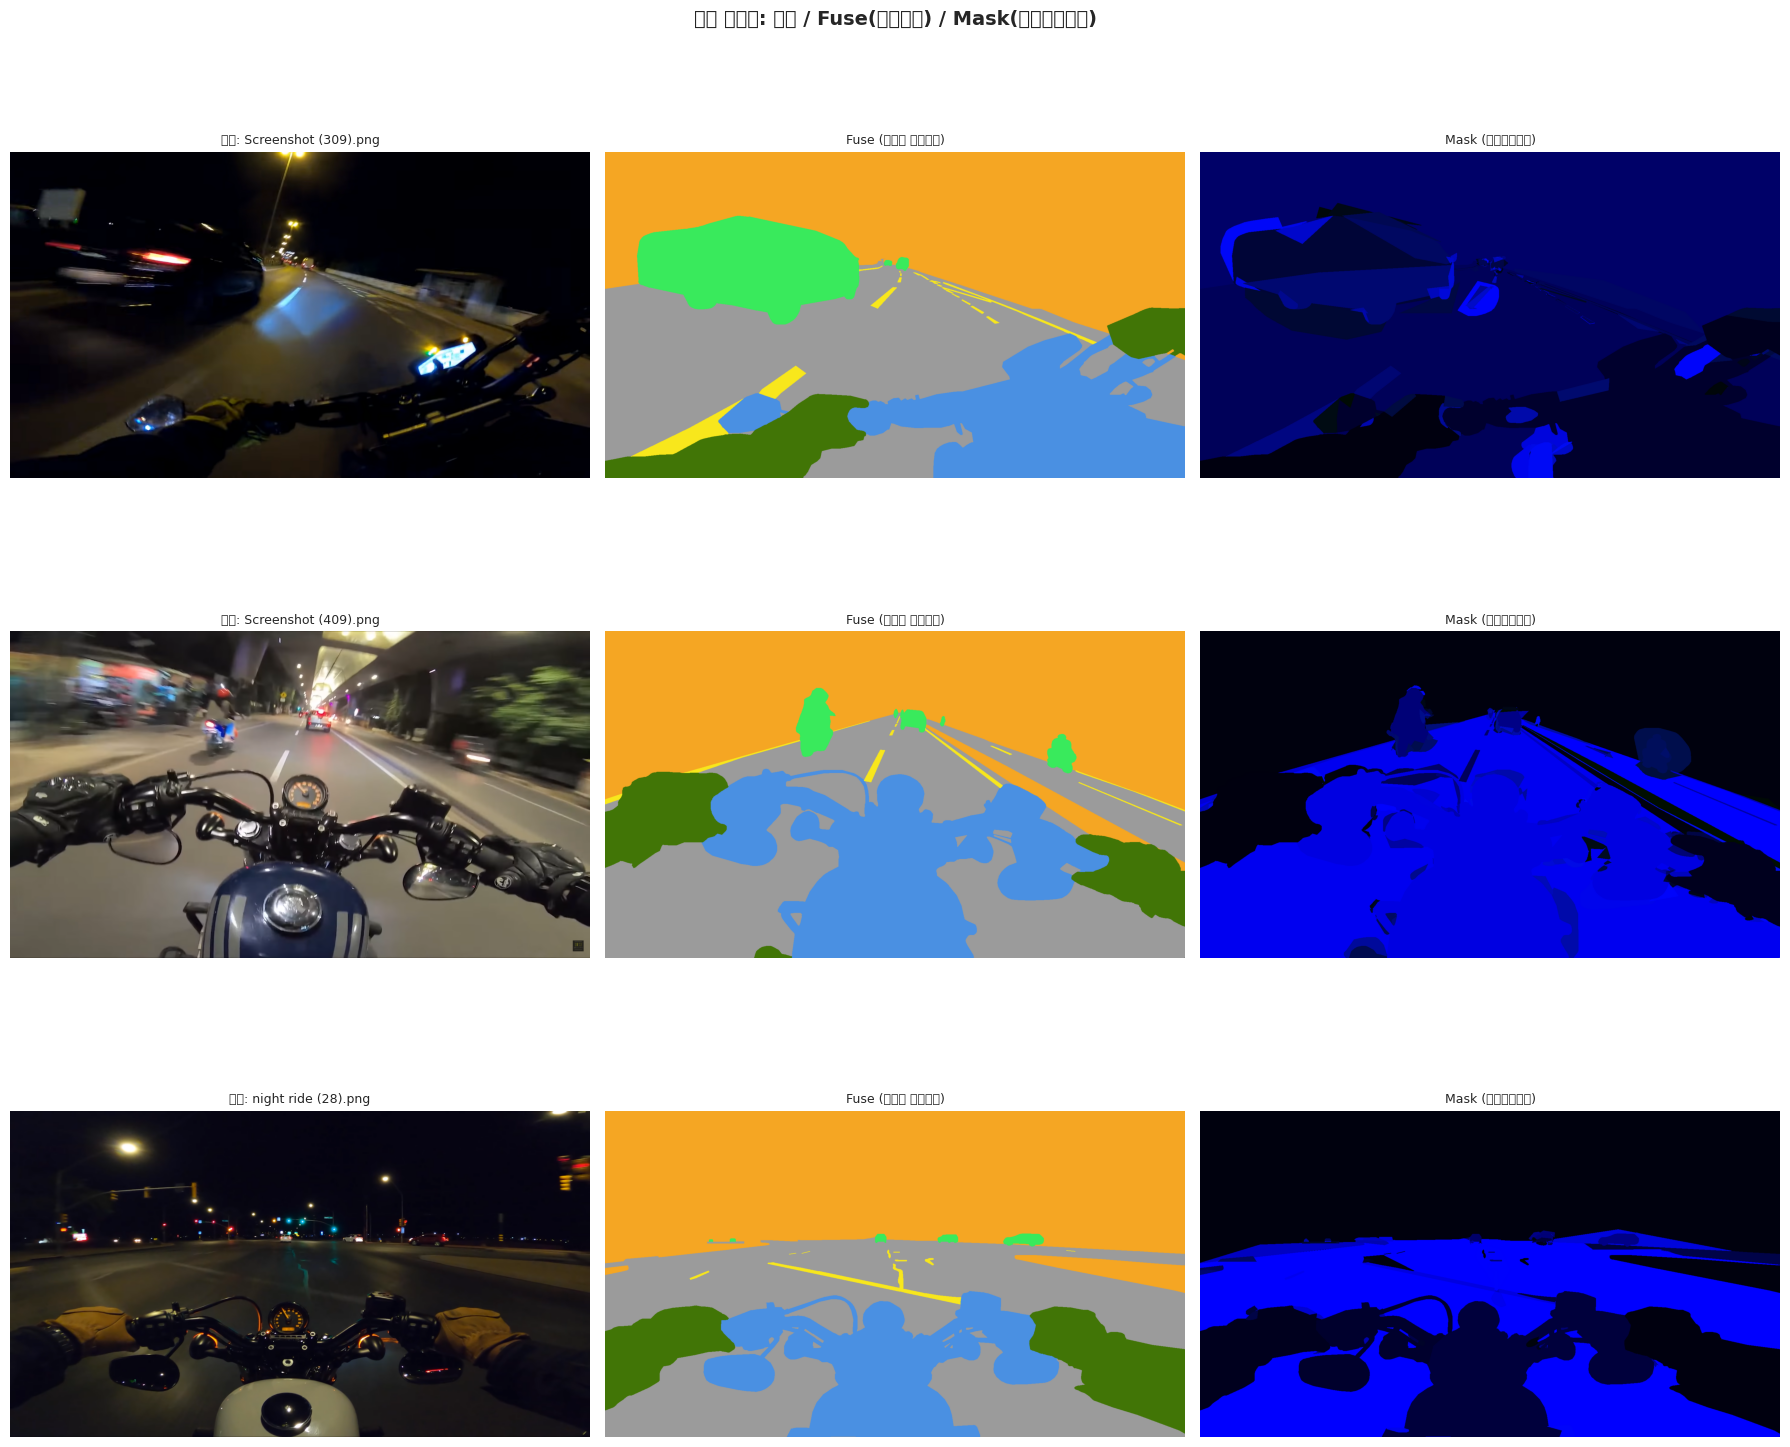


📐 이미지 해상도: (1920, 1080) (W x H)
   총 픽셀 수: 2,073,600


In [20]:
# ============================================================
# 1-3. 샘플 이미지 시각화 (원본 / Fuse / Mask)
# ============================================================
sample_indices = [0, len(original_files) // 3, 2 * len(original_files) // 3]
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

for i, idx in enumerate(sample_indices):
    orig_name = original_files[idx]
    fuse_name = orig_name + '___fuse.png'
    mask_name = orig_name + '___save.png'

    # 원본 이미지
    img_orig = Image.open(IMAGE_DIR + '/' + orig_name)
    axes[i, 0].imshow(img_orig)
    axes[i, 0].set_title(f'원본: {orig_name}', fontsize=9)
    axes[i, 0].axis('off')

    # Fuse 이미지 (마스크 오버레이)
    if fuse_name in fuse_files:
        img_fuse = Image.open(IMAGE_DIR + '/' + fuse_name)
        axes[i, 1].imshow(img_fuse)
    axes[i, 1].set_title('Fuse (마스크 오버레이)', fontsize=9)
    axes[i, 1].axis('off')

    # Mask 이미지 (세그멘테이션 마스크)
    if mask_name in mask_files:
        img_mask = Image.open(IMAGE_DIR + '/' + mask_name)
        axes[i, 2].imshow(img_mask)
    axes[i, 2].set_title('Mask (세그멘테이션)', fontsize=9)
    axes[i, 2].axis('off')

plt.suptitle('샘플 이미지: 원본 / Fuse(오버레이) / Mask(세그멘테이션)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 이미지 해상도 확인
sample_img = Image.open(IMAGE_DIR + '/' + original_files[0])
print(f'\n📐 이미지 해상도: {sample_img.size} (W x H)')
print(f'   총 픽셀 수: {sample_img.size[0] * sample_img.size[1]:,}')


📊 클래스별 어노테이션 통계:


,클래스,총면적,평균면적,어노테이션수
5,Undrivable,177854442,889272.210000,200
4,Road,112426375,562131.875000,200
2,My bike,65512489,327562.445000,200
3,Rider,33430309,167151.545000,200
1,Moveable,19523303,15041.065485,1298
0,Lane Mark,5966708,28824.676329,207


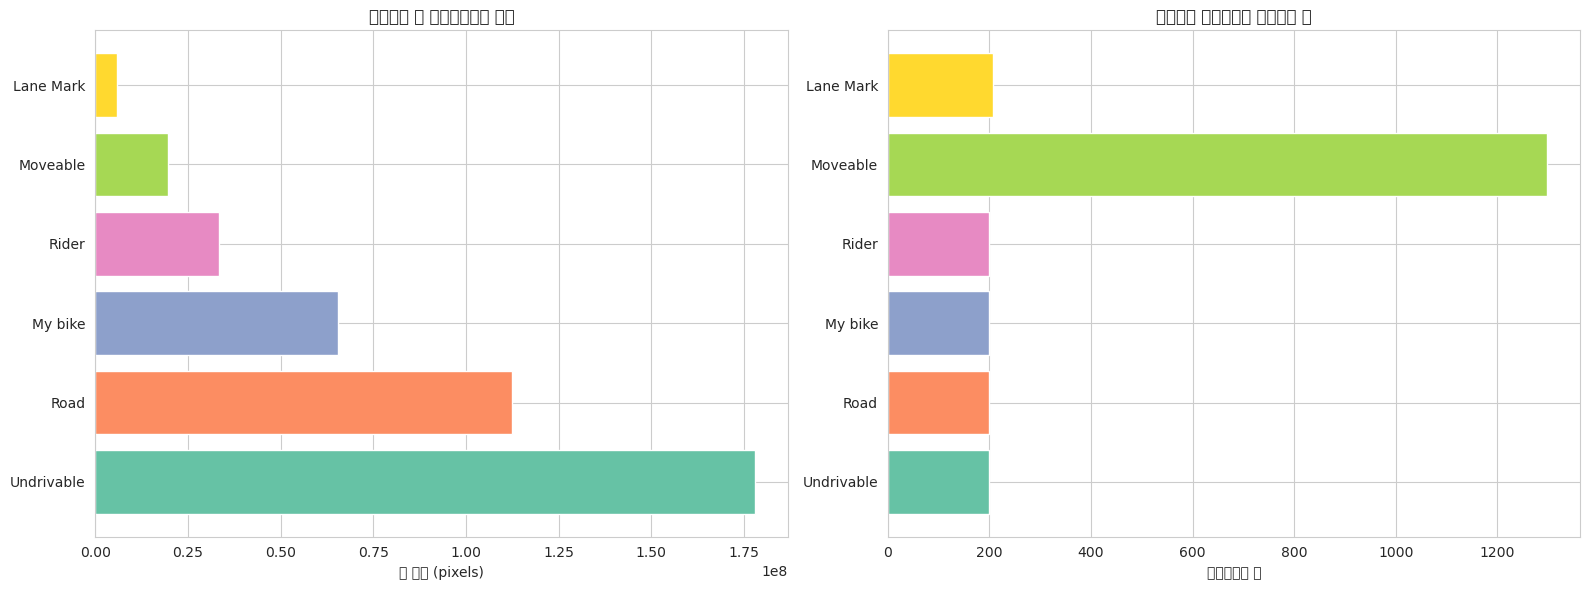


📌 분석 포인트:
  - Road/Undrivable 면적이 가장 큼 → 도로 장면의 대부분을 차지
  - Movable은 인스턴스 수가 많음 → 다중 차량/보행자
  - Lanemark 면적은 작지만 안전에 중요한 feature


In [21]:
# ============================================================
# 1-4. COCO 어노테이션 기반 클래스별 면적 분석
# ============================================================
images_df = pd.DataFrame(images_info)
ann_df = pd.DataFrame(annotations_info)

# image별 총 픽셀 수
images_df['total_pixels'] = images_df['width'] * images_df['height']

# annotation별 category name 추가
ann_df['cat_name'] = ann_df['category_id'].map(cat_id_to_name)

# 이미지별, 카테고리별 면적 합계 (동일 클래스 내 다중 인스턴스 처리)
area_by_cat = ann_df.groupby(['image_id', 'cat_name'])['area'].sum().reset_index()
area_by_cat.columns = ['image_id', 'cat_name', 'total_area']

# 전체 데이터셋 클래스별 통계
class_stats = ann_df.groupby('cat_name')['area'].agg(['sum', 'mean', 'count']).reset_index()
class_stats.columns = ['클래스', '총면적', '평균면적', '어노테이션수']
class_stats = class_stats.sort_values('총면적', ascending=False)

print('📊 클래스별 어노테이션 통계:')
display(class_stats)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors_palette = sns.color_palette('Set2', len(class_stats))

axes[0].barh(class_stats['클래스'], class_stats['총면적'], color=colors_palette)
axes[0].set_xlabel('총 면적 (pixels)')
axes[0].set_title('클래스별 총 세그멘테이션 면적')

axes[1].barh(class_stats['클래스'], class_stats['어노테이션수'], color=colors_palette)
axes[1].set_xlabel('어노테이션 수')
axes[1].set_title('클래스별 어노테이션 인스턴스 수')

plt.tight_layout()
plt.show()

print('\n📌 분석 포인트:')
print('  - Road/Undrivable 면적이 가장 큼 → 도로 장면의 대부분을 차지')
print('  - Movable은 인스턴스 수가 많음 → 다중 차량/보행자')
print('  - Lanemark 면적은 작지만 안전에 중요한 feature')


📊 이미지별 클래스 면적 비율 통계:


cat_name,Lane Mark,Moveable,My bike,Rider,Road,Undrivable
count,200.0000,200.0000,200.0000,200.0000,200.0000,200.0000
mean,0.0144,0.0471,0.1580,0.0806,0.2711,0.4289
std,0.0132,0.0603,0.0428,0.0202,0.0792,0.0871
min,0.0000,0.0000,0.0523,0.0196,0.0708,0.1694
25%,0.0050,0.0034,0.1274,0.0739,0.2321,0.3802
50%,0.0112,0.0223,0.1542,0.0873,0.2864,0.4310
75%,0.0196,0.0688,0.1815,0.0933,0.3172,0.4742
max,0.0820,0.3023,0.3431,0.1301,0.4992,0.7308


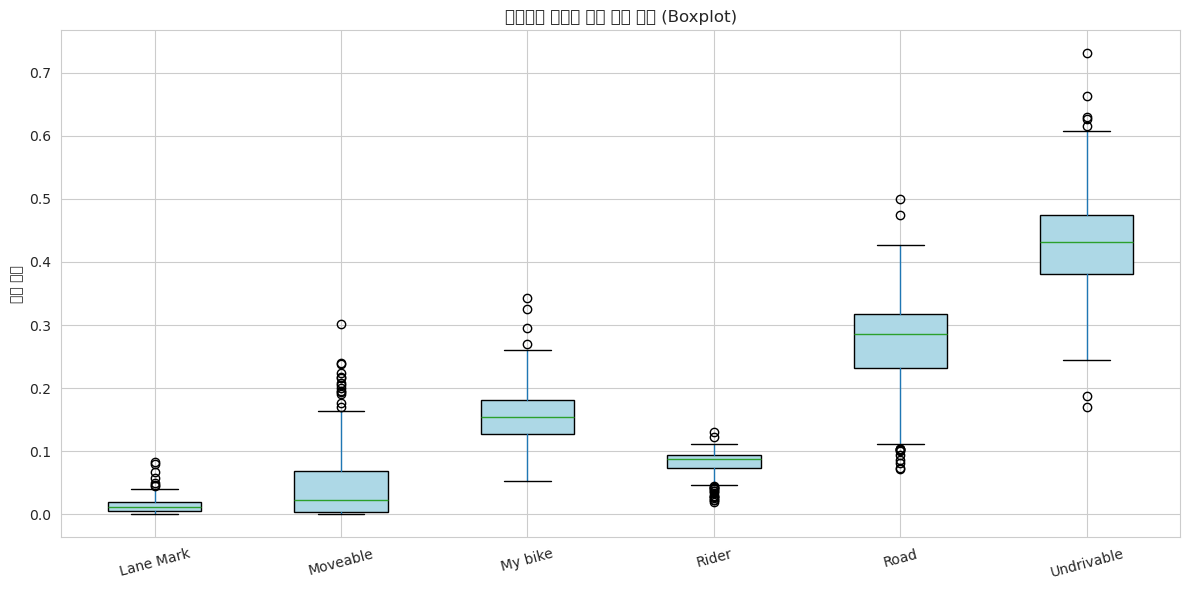

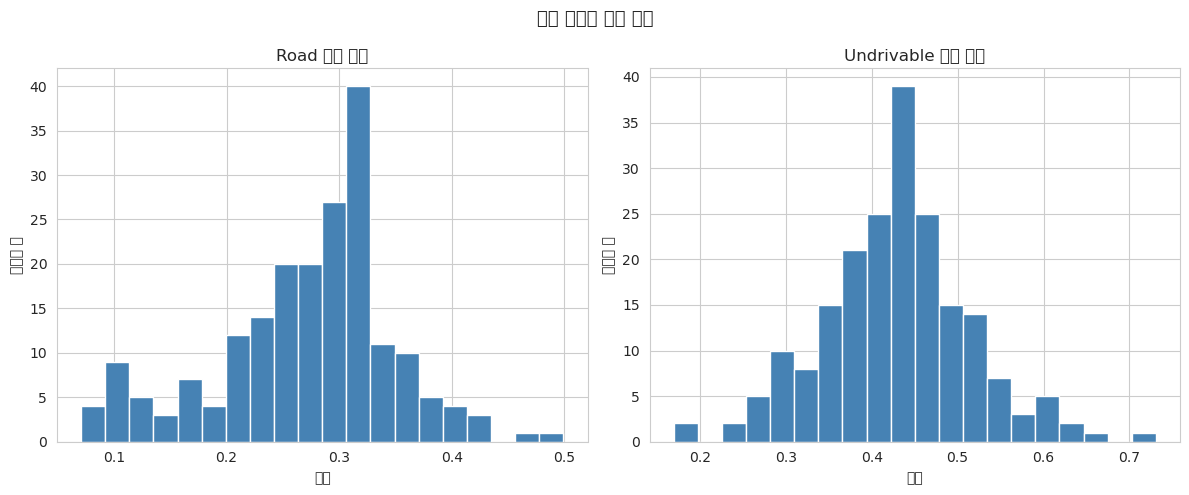

In [22]:
# ============================================================
# 1-5. 이미지별 클래스 비율 분포 분석
# ============================================================
# pivot: image_id × cat_name → area
pivot_area = area_by_cat.pivot_table(
    index='image_id', columns='cat_name', values='total_area', fill_value=0
)

# 이미지 크기로 나누어 비율 계산
img_pixels = images_df.set_index('id')['total_pixels']
pivot_ratio = pivot_area.div(img_pixels, axis=0)

print('📊 이미지별 클래스 면적 비율 통계:')
display(pivot_ratio.describe().round(4))

# 박스플롯
fig, ax = plt.subplots(figsize=(12, 6))
pivot_ratio.boxplot(ax=ax, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue'))
ax.set_ylabel('면적 비율')
ax.set_title('이미지별 클래스 면적 비율 분포 (Boxplot)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 핵심 클래스 히스토그램
key_classes = [c for c in ['Road', 'Movable', 'Undrivable'] if c in pivot_ratio.columns]
if key_classes:
    fig, axes = plt.subplots(1, len(key_classes), figsize=(6 * len(key_classes), 5))
    if len(key_classes) == 1:
        axes = [axes]
    for ax, col in zip(axes, key_classes):
        pivot_ratio[col].hist(bins=20, ax=ax, color='steelblue', edgecolor='white')
        ax.set_title(f'{col} 비율 분포')
        ax.set_xlabel('비율')
        ax.set_ylabel('프레임 수')
    plt.suptitle('핵심 클래스 비율 분포', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()


---
# 2. 데이터 전처리

EDA 결과를 바탕으로 안전 점수 산출을 위한 **Feature DataFrame**을 구축합니다.
- 이미지별 6개 클래스 비율 + Background 비율 → Feature 벡터
- 결측값 처리 및 Feature 간 상관관계 분석


In [23]:
# ============================================================
# 2-1. Feature DataFrame 구축
# ============================================================
feature_df = pivot_ratio.copy().reset_index()

# 파일명 매핑
id_to_filename = images_df.set_index('id')['file_name'].to_dict()
feature_df['file_name'] = feature_df['image_id'].map(id_to_filename)

# 클래스 컬럼 식별
class_columns = [c for c in feature_df.columns if c not in ['image_id', 'file_name']]

# 결측값 처리 (어노테이션이 없는 클래스 → 0)
feature_df[class_columns] = feature_df[class_columns].fillna(0)

# Background 비율 추가 (1 - 모든 클래스 비율 합)
feature_df['Background'] = (1 - feature_df[class_columns].sum(axis=1)).clip(lower=0)

print(f'📊 Feature DataFrame 형태: {feature_df.shape}')
print(f'📋 컬럼: {list(feature_df.columns)}')
print(f'\n처음 5행:')
display(feature_df.head())
print(f'\n기본 통계:')
display(feature_df[class_columns + ['Background']].describe().round(4))

# 결측값 확인
missing = feature_df.isnull().sum()
print(f'\n📋 결측값 확인:')
print(missing[missing > 0] if missing.sum() > 0 else '  결측값 없음 ✅')


📊 Feature DataFrame 형태: (200, 9)
📋 컬럼: ['image_id', 'Lane Mark', 'Moveable', 'My bike', 'Rider', 'Road', 'Undrivable', 'file_name', 'Background']

처음 5행:


cat_name,image_id,Lane Mark,Moveable,My bike,Rider,Road,Undrivable,file_name,Background
0,1,0.008398,0.005705,0.177700,0.130130,0.395211,0.282856,night ride (8).png,0.0
1,2,0.005537,0.068690,0.129867,0.089529,0.295850,0.410526,night ride (14).png,0.0
2,3,0.001420,0.107863,0.139966,0.090835,0.222433,0.437483,night ride (11).png,0.0
3,4,0.024300,0.043197,0.083048,0.047204,0.309953,0.492297,night ride (24).png,0.0
4,5,0.027670,0.018434,0.148387,0.098276,0.312914,0.394319,night ride (23).png,0.0



기본 통계:


cat_name,Lane Mark,Moveable,My bike,Rider,Road,Undrivable,Background
count,200.0000,200.0000,200.0000,200.0000,200.0000,200.0000,200.0000
mean,0.0144,0.0471,0.1580,0.0806,0.2711,0.4289,0.0000
std,0.0132,0.0603,0.0428,0.0202,0.0792,0.0871,0.0001
min,0.0000,0.0000,0.0523,0.0196,0.0708,0.1694,0.0000
25%,0.0050,0.0034,0.1274,0.0739,0.2321,0.3802,0.0000
50%,0.0112,0.0223,0.1542,0.0873,0.2864,0.4310,0.0000
75%,0.0196,0.0688,0.1815,0.0933,0.3172,0.4742,0.0000
max,0.0820,0.3023,0.3431,0.1301,0.4992,0.7308,0.0007



📋 결측값 확인:
  결측값 없음 ✅


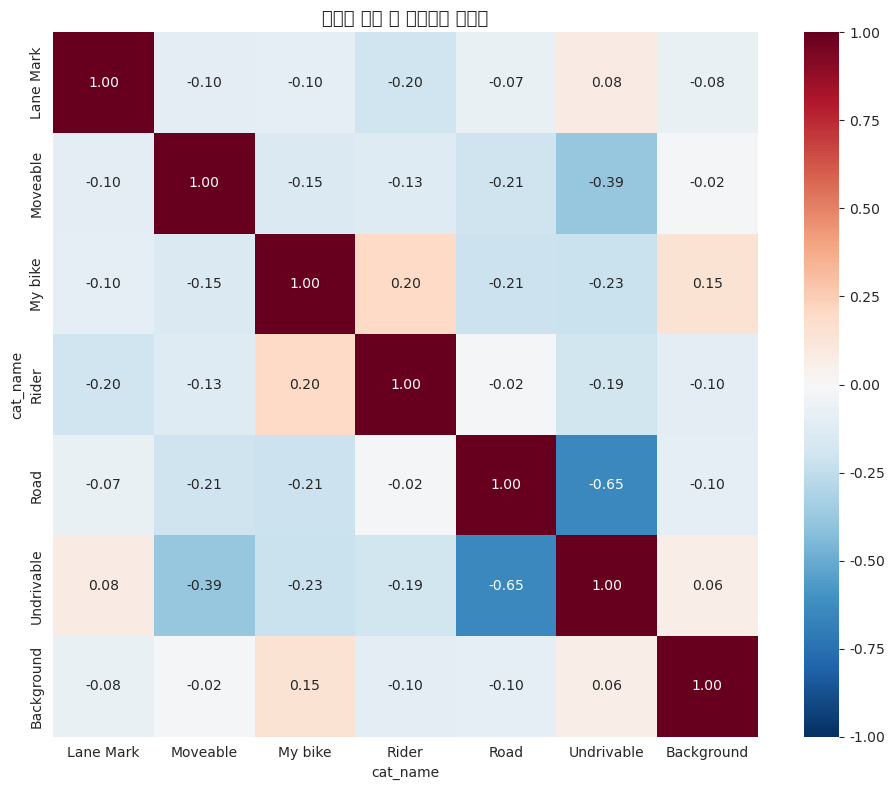

📌 주요 상관관계 해석:
  - Road ↔ Undrivable: 반비례 → 도로가 넓을수록 비주행영역이 좁다
  - Movable ↔ Road: 차량이 많을수록 도로 면적에 영향
  - Background 비율이 높으면 → 라벨링되지 않은 영역(하늘, 어둠 등)
  ⇒ Road, Undrivable, Movable이 안전 점수에 핵심 Feature가 될 것


In [24]:
# ============================================================
# 2-2. Feature 상관관계 분석
# ============================================================
corr_cols = class_columns + ['Background']
corr_matrix = feature_df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=ax, vmin=-1, vmax=1)
ax.set_title('클래스 비율 간 상관관계 히트맵', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('📌 주요 상관관계 해석:')
print('  - Road ↔ Undrivable: 반비례 → 도로가 넓을수록 비주행영역이 좁다')
print('  - Movable ↔ Road: 차량이 많을수록 도로 면적에 영향')
print('  - Background 비율이 높으면 → 라벨링되지 않은 영역(하늘, 어둠 등)')
print('  ⇒ Road, Undrivable, Movable이 안전 점수에 핵심 Feature가 될 것')


---
# 3. 규칙 기반 안전 점수 설계

세만틱 세그멘테이션의 클래스별 비율을 활용하여 **규칙 기반 안전 점수**를 산출합니다.

### 설계 논리
- **Road 비율 ↑** → 전방 도로가 넓고 명확 → **안전도 증가** (+0.35)
- **Lanemark 비율 ↑** → 차선이 잘 보임 → **안전도 증가** (+0.15)
- **Undrivable 비율 ↑** → 비주행 영역이 가까움 → **위험도 증가** (-0.25)
- **Movable 비율 ↑** → 다른 차량/보행자 존재 → **위험도 증가** (-0.25)

$$\text{safety\_raw} = 0.35 \times \text{Road} + 0.15 \times \text{Lanemark} - 0.25 \times \text{Undrivable} - 0.25 \times \text{Movable}$$

→ MinMax 정규화하여 **0~100** 스케일로 변환 후 3등급 분류:
- **Safe** (≥66) / **Caution** (33~66) / **Dangerous** (<33)


In [25]:
# ============================================================
# 3-1. 안전 점수 계산
# ============================================================
# 가중치 설정
W_ROAD = 0.35
W_LANEMARK = 0.15
W_UNDRIVABLE = -0.25
W_MOVABLE = -0.25

def compute_safety_score(row, cols):
    """규칙 기반 안전 점수 산출 함수"""
    score = 0
    if 'Road' in cols:
        score += W_ROAD * row.get('Road', 0)
    if 'Lanemark' in cols:
        score += W_LANEMARK * row.get('Lanemark', 0)
    if 'Undrivable' in cols:
        score += W_UNDRIVABLE * row.get('Undrivable', 0)
    if 'Movable' in cols:
        score += W_MOVABLE * row.get('Movable', 0)
    return score

# 원점수 계산
feature_df['safety_raw'] = feature_df.apply(
    lambda row: compute_safety_score(row, class_columns), axis=1
)

# MinMax 정규화 → 0~100
s_min = feature_df['safety_raw'].min()
s_max = feature_df['safety_raw'].max()
feature_df['safety_score'] = (
    (feature_df['safety_raw'] - s_min) / (s_max - s_min) * 100
).round(1)

# 안전 등급 부여 (3등급)
def assign_grade(score):
    if score >= 66:
        return 'Safe'
    elif score >= 33:
        return 'Caution'
    else:
        return 'Dangerous'

feature_df['safety_grade'] = feature_df['safety_score'].apply(assign_grade)

print('✅ 안전 점수 산출 완료\n')
print(f'📊 안전 점수 기본 통계:')
print(feature_df['safety_score'].describe().round(1))
print(f'\n📊 안전 등급 분포:')
print(feature_df['safety_grade'].value_counts())
print(f'\n📋 가중치 설정:')
print(f'  Road:       {W_ROAD:+.2f}')
print(f'  Lanemark:   {W_LANEMARK:+.2f}')
print(f'  Undrivable: {W_UNDRIVABLE:+.2f}')
print(f'  Movable:    {W_MOVABLE:+.2f}')


✅ 안전 점수 산출 완료

📊 안전 점수 기본 통계:
count    200.0
mean      56.1
std       17.3
min        0.0
25%       48.5
50%       58.3
75%       66.4
max      100.0
Name: safety_score, dtype: float64

📊 안전 등급 분포:
safety_grade
Caution      124
Safe          53
Dangerous     23
Name: count, dtype: int64

📋 가중치 설정:
  Road:       +0.35
  Lanemark:   +0.15
  Undrivable: -0.25
  Movable:    -0.25


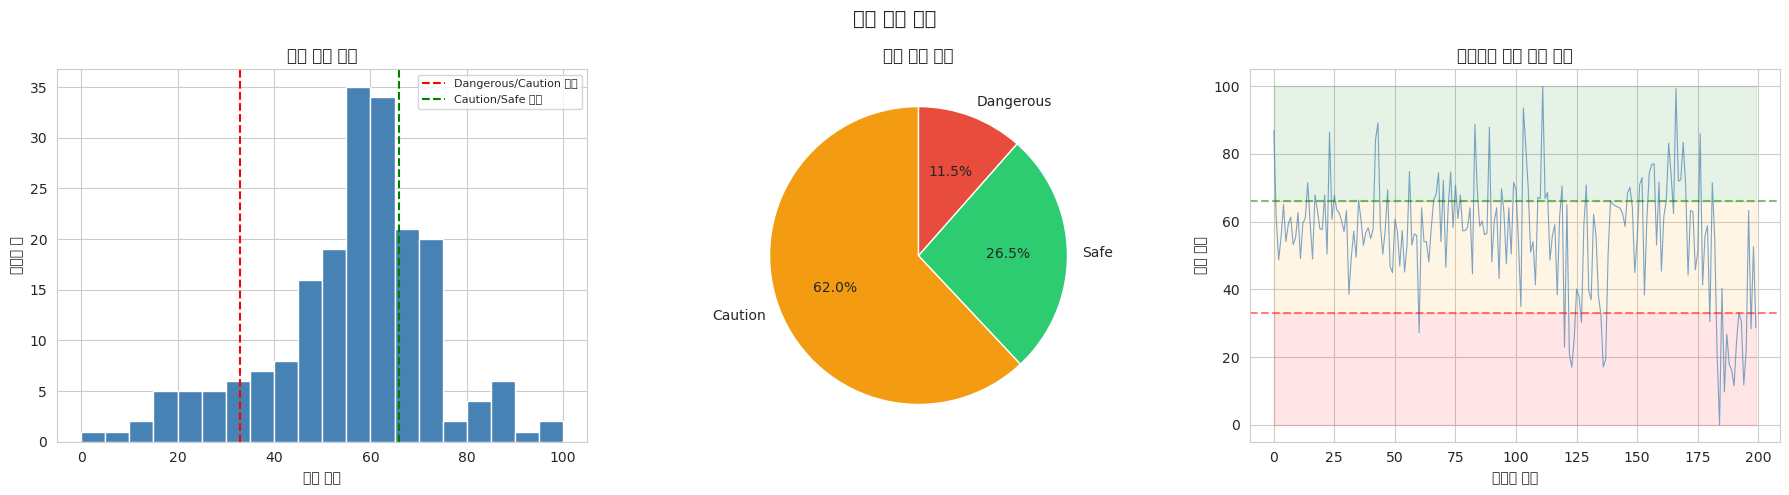

In [26]:
# ============================================================
# 3-2. 안전 점수 분포 시각화
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 히스토그램
axes[0].hist(feature_df['safety_score'], bins=20, color='steelblue', edgecolor='white')
axes[0].axvline(33, color='red', linestyle='--', label='Dangerous/Caution 경계')
axes[0].axvline(66, color='green', linestyle='--', label='Caution/Safe 경계')
axes[0].set_xlabel('안전 점수')
axes[0].set_ylabel('프레임 수')
axes[0].set_title('안전 점수 분포')
axes[0].legend(fontsize=8)

# 2. 등급별 파이차트
grade_counts = feature_df['safety_grade'].value_counts()
colors_pie = {'Safe': '#2ecc71', 'Caution': '#f39c12', 'Dangerous': '#e74c3c'}
pie_colors = [colors_pie.get(g, 'gray') for g in grade_counts.index]
axes[1].pie(grade_counts.values, labels=grade_counts.index, autopct='%1.1f%%',
            colors=pie_colors, startangle=90)
axes[1].set_title('안전 등급 분포')

# 3. 프레임 순서별 안전 점수 추이
axes[2].plot(range(len(feature_df)), feature_df['safety_score'].values,
             color='steelblue', alpha=0.7, linewidth=0.8)
axes[2].axhline(33, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(66, color='green', linestyle='--', alpha=0.5)
axes[2].fill_between(range(len(feature_df)), 0, 33, alpha=0.1, color='red')
axes[2].fill_between(range(len(feature_df)), 33, 66, alpha=0.1, color='orange')
axes[2].fill_between(range(len(feature_df)), 66, 100, alpha=0.1, color='green')
axes[2].set_xlabel('프레임 번호')
axes[2].set_ylabel('안전 점수')
axes[2].set_title('프레임별 안전 점수 추이')

plt.suptitle('안전 점수 분석', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


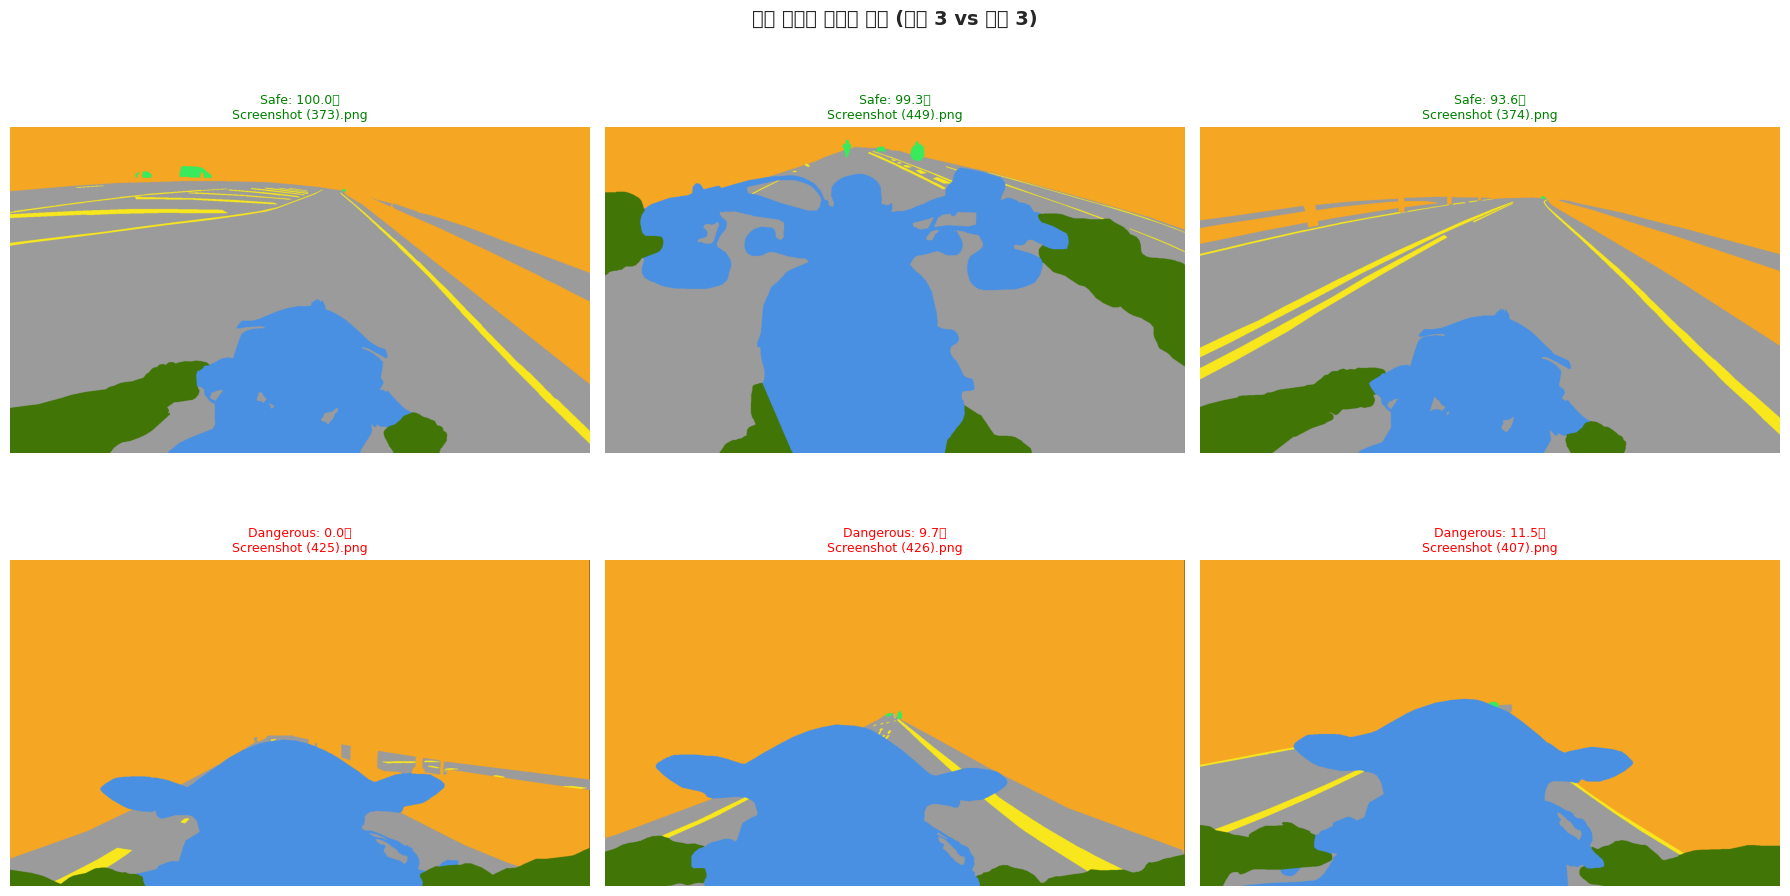

📌 해석:
  - Safe 프레임: 넓은 도로, 적은 장애물, 명확한 차선
  - Dangerous 프레임: 좁은 도로, 많은 차량/보행자, 비주행 영역 증가


In [31]:
# ============================================================
# 3-3. 안전/위험 프레임 비교 시각화
# ============================================================
safe_frames = feature_df.nlargest(3, 'safety_score')
dangerous_frames = feature_df.nsmallest(3, 'safety_score')

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (_, row) in enumerate(safe_frames.iterrows()):
    fname = row['file_name']
    fuse_path = IMAGE_DIR + '/' + (fname + '___fuse.png')
    orig_path = IMAGE_DIR + '/' + fname
    img_path = fuse_path if os.path.exists(fuse_path) else orig_path
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[0, i].imshow(img)
    score_val = row['safety_score']
    axes[0, i].set_title(f'Safe: {score_val}점\n{fname}', fontsize=9, color='green')
    axes[0, i].axis('off')

for i, (_, row) in enumerate(dangerous_frames.iterrows()):
    fname = row['file_name']
    fuse_path = IMAGE_DIR + '/' + (fname + '___fuse.png')
    orig_path = IMAGE_DIR + '/' + fname
    img_path = fuse_path if os.path.exists(fuse_path) else orig_path
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[1, i].imshow(img)
    score_val = row['safety_score']
    axes[1, i].set_title(f'Dangerous: {score_val}점\n{fname}', fontsize=9, color='red')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('🟢 Safe', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('🔴 Dangerous', fontsize=14, fontweight='bold')
plt.suptitle('안전 등급별 프레임 비교 (상위 3 vs 하위 3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('📌 해석:')
print('  - Safe 프레임: 넓은 도로, 적은 장애물, 명확한 차선')
print('  - Dangerous 프레임: 좁은 도로, 많은 차량/보행자, 비주행 영역 증가')


---
# 4. 모델 선정 및 학습

### 모델 선정 근거
- 데이터 수가 약 200장으로 적으므로 고용량 딥러닝 모델 대신 해석 가능한 피처 기반 모델 선택
- 세그멘테이션은 이미 제공된 라벨을 활용하여 downstream task (안전 등급 분류)에 집중
- 안전 점수는 설명력이 중요하므로 Feature Importance를 볼 수 있는 모델 유리

### 실험 계획
- **실험 1**: Logistic Regression (Baseline, 선형 모델)
- **실험 2**: Random Forest (비선형, 앙상블, Feature Importance)
- **실험 3**: Gradient Boosting (부스팅 기반, 높은 성능 기대)


In [32]:
# ============================================================
# 실험 1: Logistic Regression (Baseline)
# ============================================================
# Feature / Target 준비
feature_cols = [c for c in class_columns if c in feature_df.columns] + ['Background']
X = feature_df[feature_cols].values
y = feature_df['safety_grade'].values

# Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f'📋 클래스: {list(le.classes_)}')
print(f'📊 데이터 shape: X={X.shape}, y={y_encoded.shape}')

# Train/Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f'   Train: {X_train.shape[0]}개, Test: {X_test.shape[0]}개')

# StandardScaler (Logistic Regression용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

lr_acc = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='macro')

print(f'\n🔬 실험 1: Logistic Regression')
print(f'   Accuracy: {lr_acc:.4f}')
print(f'   Macro F1: {lr_f1:.4f}')
print(f'\n{classification_report(y_test, lr_pred, target_names=le.classes_)}')

# 결과 저장
results = []
results.append({
    'Model': 'Logistic Regression', 'Accuracy': lr_acc,
    'Macro_F1': lr_f1, 'Features': 'Basic'
})


📋 클래스: ['Caution', 'Dangerous', 'Safe']
📊 데이터 shape: X=(200, 7), y=(200,)
   Train: 160개, Test: 40개

🔬 실험 1: Logistic Regression
   Accuracy: 0.9000
   Macro F1: 0.8878

              precision    recall  f1-score   support

     Caution       1.00      0.88      0.94        25
   Dangerous       0.83      1.00      0.91         5
        Safe       0.75      0.90      0.82        10

    accuracy                           0.90        40
   macro avg       0.86      0.93      0.89        40
weighted avg       0.92      0.90      0.90        40



In [33]:
# ============================================================
# 실험 2: Random Forest
# ============================================================
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'
)
rf_model.fit(X_train, y_train)  # RF는 스케일링 불필요
rf_pred = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='macro')

print(f'🔬 실험 2: Random Forest')
print(f'   Accuracy: {rf_acc:.4f}')
print(f'   Macro F1: {rf_f1:.4f}')
print(f'\n{classification_report(y_test, rf_pred, target_names=le.classes_)}')

results.append({
    'Model': 'Random Forest', 'Accuracy': rf_acc,
    'Macro_F1': rf_f1, 'Features': 'Basic'
})

# Feature Importance (초기 확인)
feat_imp = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(f'\n📊 Random Forest Feature Importance:')
for fname, imp in feat_imp.items():
    bar = '█' * int(imp * 50)
    print(f'   {fname:>15s}: {imp:.4f} {bar}')


🔬 실험 2: Random Forest
   Accuracy: 0.9250
   Macro F1: 0.9278

              precision    recall  f1-score   support

     Caution       0.92      0.96      0.94        25
   Dangerous       1.00      1.00      1.00         5
        Safe       0.89      0.80      0.84        10

    accuracy                           0.93        40
   macro avg       0.94      0.92      0.93        40
weighted avg       0.92      0.93      0.92        40


📊 Random Forest Feature Importance:
              Road: 0.4145 ████████████████████
        Undrivable: 0.3405 █████████████████
           My bike: 0.0812 ████
          Moveable: 0.0667 ███
             Rider: 0.0475 ██
         Lane Mark: 0.0348 █
        Background: 0.0147 


In [34]:
# ============================================================
# 실험 3: Gradient Boosting
# ============================================================
gb_model = GradientBoostingClassifier(
    n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

gb_acc = accuracy_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred, average='macro')

print(f'🔬 실험 3: Gradient Boosting')
print(f'   Accuracy: {gb_acc:.4f}')
print(f'   Macro F1: {gb_f1:.4f}')
print(f'\n{classification_report(y_test, gb_pred, target_names=le.classes_)}')

results.append({
    'Model': 'Gradient Boosting', 'Accuracy': gb_acc,
    'Macro_F1': gb_f1, 'Features': 'Basic'
})

# 실험 1~3 비교
results_df = pd.DataFrame(results)
print('\n📊 실험 1~3 결과 비교:')
display(results_df)


🔬 실험 3: Gradient Boosting
   Accuracy: 0.9250
   Macro F1: 0.9352

              precision    recall  f1-score   support

     Caution       1.00      0.88      0.94        25
   Dangerous       1.00      1.00      1.00         5
        Safe       0.77      1.00      0.87        10

    accuracy                           0.93        40
   macro avg       0.92      0.96      0.94        40
weighted avg       0.94      0.93      0.93        40


📊 실험 1~3 결과 비교:


,Model,Accuracy,Macro_F1,Features
0,Logistic Regression,0.900,0.887814,Basic
1,Random Forest,0.925,0.927761,Basic
2,Gradient Boosting,0.925,0.935245,Basic


---
# 5. 성능 향상

논리적이고 단계적인 접근으로 성능을 개선합니다.

### 접근 전략
1. **파생 Feature 추가**: 도메인 지식 기반의 복합 Feature 생성
   - Road vs Undrivable 차이, Movable/Road 밀도, 주행가능비율, 위험요소 총합
2. **K-Fold Cross Validation**: 200장의 적은 데이터에서 안정적 평가
3. **하이퍼파라미터 튜닝**: GridSearchCV로 최적 파라미터 탐색


In [35]:
# ============================================================
# 5-1. 파생 Feature 추가 + 실험 4
# ============================================================
feature_df_adv = feature_df.copy()

# 1. Road vs Undrivable 비율 차이 (도로 우세 정도)
if 'Road' in feature_df_adv.columns and 'Undrivable' in feature_df_adv.columns:
    feature_df_adv['road_undrivable_diff'] = feature_df_adv['Road'] - feature_df_adv['Undrivable']

# 2. Movable/Road 비율 (도로 위 차량 밀도 대리지표)
if 'Road' in feature_df_adv.columns and 'Movable' in feature_df_adv.columns:
    feature_df_adv['movable_road_ratio'] = feature_df_adv['Movable'] / (feature_df_adv['Road'] + 1e-6)

# 3. Lanemark/Road 비율 (차선 가시성)
if 'Road' in feature_df_adv.columns and 'Lanemark' in feature_df_adv.columns:
    feature_df_adv['lanemark_road_ratio'] = feature_df_adv['Lanemark'] / (feature_df_adv['Road'] + 1e-6)

# 4. 주행 가능 영역 비율 (Road + Lanemark)
drivable = feature_df_adv.get('Road', 0)
if 'Lanemark' in feature_df_adv.columns:
    drivable = drivable + feature_df_adv['Lanemark']
feature_df_adv['drivable_ratio'] = drivable

# 5. 위험 요소 총합 (Undrivable + Movable)
hazard = 0
if 'Undrivable' in feature_df_adv.columns:
    hazard = hazard + feature_df_adv['Undrivable']
if 'Movable' in feature_df_adv.columns:
    hazard = hazard + feature_df_adv['Movable']
feature_df_adv['hazard_ratio'] = hazard

# 추가된 Feature 확인
adv_feature_cols = feature_cols + [
    'road_undrivable_diff', 'movable_road_ratio',
    'lanemark_road_ratio', 'drivable_ratio', 'hazard_ratio'
]
adv_feature_cols = [c for c in adv_feature_cols if c in feature_df_adv.columns]

print(f'📊 기존 Feature 수: {len(feature_cols)}')
print(f'📊 추가 Feature 수: {len(adv_feature_cols) - len(feature_cols)}')
print(f'📊 총 Feature 수: {len(adv_feature_cols)}')
new_feats = [c for c in adv_feature_cols if c not in feature_cols]
print(f'\n추가된 Feature: {new_feats}')

# 새로운 Feature로 데이터 준비
X_adv = feature_df_adv[adv_feature_cols].values
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_adv, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Random Forest + 파생 Feature
rf_adv = RandomForestClassifier(
    n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'
)
rf_adv.fit(X_train_adv, y_train_adv)
rf_adv_pred = rf_adv.predict(X_test_adv)

rf_adv_acc = accuracy_score(y_test_adv, rf_adv_pred)
rf_adv_f1 = f1_score(y_test_adv, rf_adv_pred, average='macro')

print(f'\n🔬 실험 4: Random Forest + 파생 Feature')
print(f'   Accuracy: {rf_adv_acc:.4f}  (기존 RF: {rf_acc:.4f})')
print(f'   Macro F1: {rf_adv_f1:.4f}  (기존 RF: {rf_f1:.4f})')

results.append({
    'Model': 'RF + Advanced Features', 'Accuracy': rf_adv_acc,
    'Macro_F1': rf_adv_f1, 'Features': 'Advanced'
})


📊 기존 Feature 수: 7
📊 추가 Feature 수: 3
📊 총 Feature 수: 10

추가된 Feature: ['road_undrivable_diff', 'drivable_ratio', 'hazard_ratio']

🔬 실험 4: Random Forest + 파생 Feature
   Accuracy: 1.0000  (기존 RF: 0.9250)
   Macro F1: 1.0000  (기존 RF: 0.9278)


In [36]:
# ============================================================
# 5-2. K-Fold Cross Validation 비교
# ============================================================
# 데이터가 ~200장으로 적으므로 5-Fold CV로 안정적 평가
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_cv = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=5, random_state=42, class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42
    ),
}

print('📊 5-Fold Cross Validation 결과 (Advanced Features 사용):\n')
cv_results = {}
scaler_cv = StandardScaler()

for name, model in models_cv.items():
    # Logistic Regression만 스케일링 적용
    if 'Logistic' in name:
        X_cv = scaler_cv.fit_transform(X_adv)
    else:
        X_cv = X_adv

    scores_acc = cross_val_score(model, X_cv, y_encoded, cv=cv, scoring='accuracy')
    scores_f1 = cross_val_score(model, X_cv, y_encoded, cv=cv, scoring='f1_macro')

    cv_results[name] = {
        'Acc_mean': scores_acc.mean(),
        'Acc_std': scores_acc.std(),
        'F1_mean': scores_f1.mean(),
        'F1_std': scores_f1.std()
    }
    print(f'  {name}:')
    print(f'    Accuracy: {scores_acc.mean():.4f} +/- {scores_acc.std():.4f}')
    print(f'    Macro F1: {scores_f1.mean():.4f} +/- {scores_f1.std():.4f}')
    print()

cv_df = pd.DataFrame(cv_results).T
print('📊 CV 결과 요약:')
display(cv_df.round(4))


📊 5-Fold Cross Validation 결과 (Advanced Features 사용):

  Logistic Regression:
    Accuracy: 0.9600 +/- 0.0406
    Macro F1: 0.9492 +/- 0.0487

  Random Forest:
    Accuracy: 0.9750 +/- 0.0158
    Macro F1: 0.9700 +/- 0.0172

  Gradient Boosting:
    Accuracy: 0.9600 +/- 0.0122
    Macro F1: 0.9564 +/- 0.0140

📊 CV 결과 요약:


,Acc_mean,Acc_std,F1_mean,F1_std
Logistic Regression,0.960,0.0406,0.9492,0.0487
Random Forest,0.975,0.0158,0.9700,0.0172
Gradient Boosting,0.960,0.0122,0.9564,0.0140


In [37]:
# ============================================================
# 5-3. 하이퍼파라미터 튜닝 (GridSearchCV)
# ============================================================
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

print('⏳ GridSearchCV 진행 중...')
grid_search.fit(X_adv, y_encoded)

print(f'🏆 최적 하이퍼파라미터: {grid_search.best_params_}')
print(f'🏆 최적 Macro F1 (CV): {grid_search.best_score_:.4f}')

# 최적 모델로 최종 평가
best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test_adv)
best_acc = accuracy_score(y_test_adv, best_pred)
best_f1 = f1_score(y_test_adv, best_pred, average='macro')

print(f'\n📊 최적 모델 Test 성능:')
print(f'   Accuracy: {best_acc:.4f}')
print(f'   Macro F1: {best_f1:.4f}')

results.append({
    'Model': 'RF Tuned + Advanced', 'Accuracy': best_acc,
    'Macro_F1': best_f1, 'Features': 'Advanced+Tuned'
})


⏳ GridSearchCV 진행 중...
🏆 최적 하이퍼파라미터: {'class_weight': 'balanced', 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 200}
🏆 최적 Macro F1 (CV): 0.9702

📊 최적 모델 Test 성능:
   Accuracy: 1.0000
   Macro F1: 1.0000


---
# 6. 결과 분석 및 Metric 평가

### Metric 선정 근거
- **Accuracy**: 전반적 정확도 (직관적이나, 클래스 불균형에 취약)
- **Macro F1-Score** (주요 metric): 각 등급을 동등하게 평가. 안전 시스템에서 모든 등급이 중요하므로 채택
- **Confusion Matrix**: "Dangerous를 Safe로 오분류"하는 치명적 오류를 확인해야 함
  - 실제 안전 시스템에서는 위험 프레임을 놓치면 사고 위험 증가 -> Recall이 중요


📊 전체 실험 결과 비교:


,Model,Accuracy,Macro_F1,Features
4,RF Tuned + Advanced,1.000,1.000000,Advanced+Tuned
3,RF + Advanced Features,1.000,1.000000,Advanced
2,Gradient Boosting,0.925,0.935245,Basic
1,Random Forest,0.925,0.927761,Basic
0,Logistic Regression,0.900,0.887814,Basic


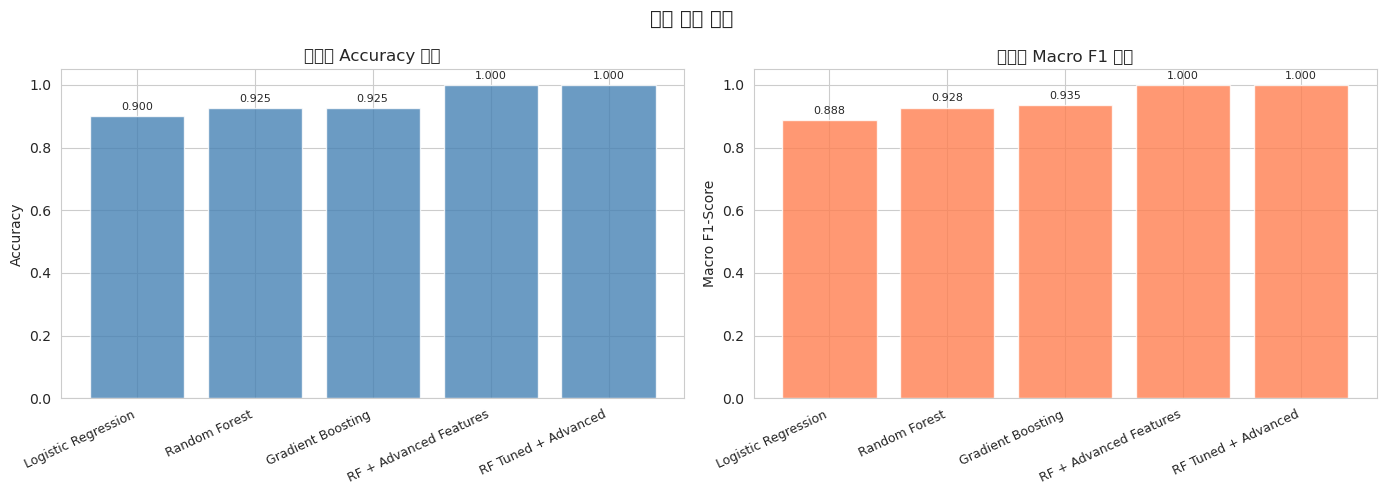

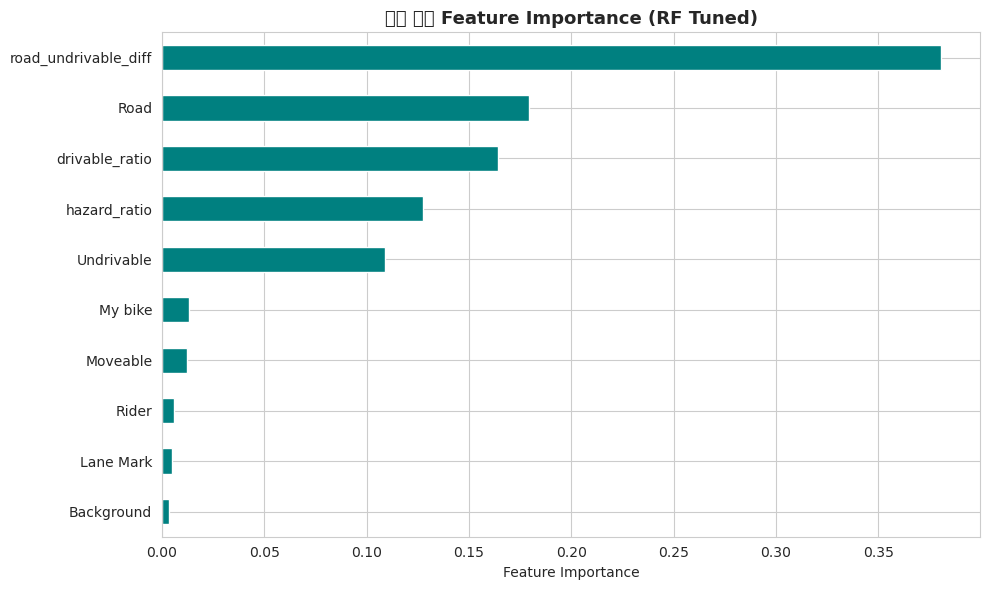


📌 Feature Importance 해석:
   road_undrivable_diff: 0.3807
   Road: 0.1791
   drivable_ratio: 0.1641


In [38]:
# ============================================================
# 6-1. 전체 실험 결과 비교 + Feature Importance
# ============================================================
results_df = pd.DataFrame(results)
print('📊 전체 실험 결과 비교:')
display(results_df.sort_values('Macro_F1', ascending=False))

# 모델별 성능 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = range(len(results_df))
axes[0].bar(x_pos, results_df['Accuracy'], color='steelblue', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=25, ha='right', fontsize=9)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('모델별 Accuracy 비교')
axes[0].set_ylim(0, 1.05)
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=8)

axes[1].bar(x_pos, results_df['Macro_F1'], color='coral', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=25, ha='right', fontsize=9)
axes[1].set_ylabel('Macro F1-Score')
axes[1].set_title('모델별 Macro F1 비교')
axes[1].set_ylim(0, 1.05)
for i, v in enumerate(results_df['Macro_F1']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=8)

plt.suptitle('모델 성능 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature Importance (최적 모델)
feat_imp_final = pd.Series(
    best_model.feature_importances_, index=adv_feature_cols
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
feat_imp_final.plot(kind='barh', ax=ax, color='teal')
ax.set_xlabel('Feature Importance')
ax.set_title('최적 모델 Feature Importance (RF Tuned)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n📌 Feature Importance 해석:')
top3 = feat_imp_final.nlargest(3)
for fname, imp in top3.items():
    print(f'   {fname}: {imp:.4f}')


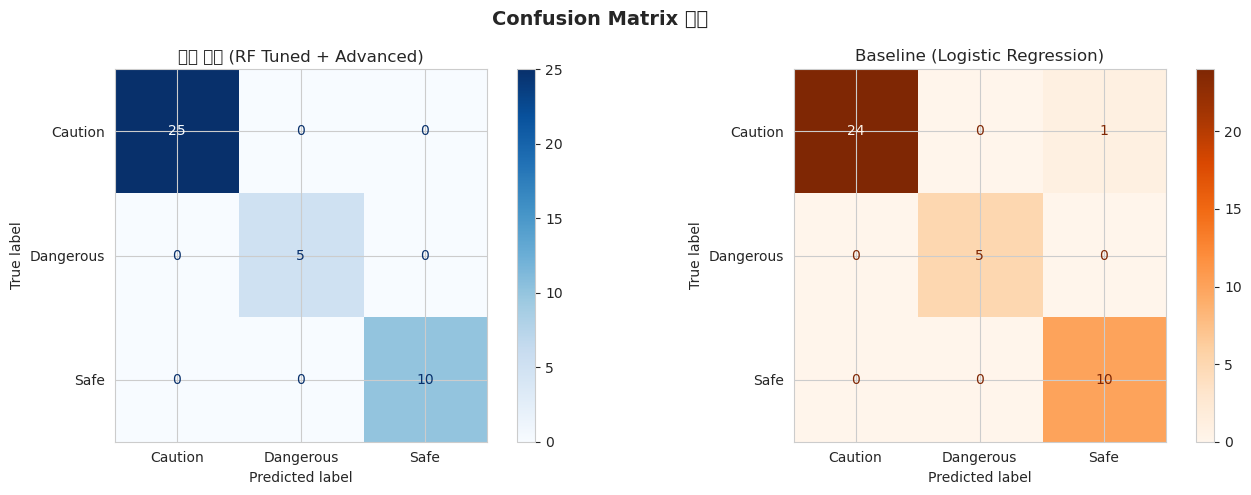


📋 최적 모델 Classification Report:
              precision    recall  f1-score   support

     Caution       1.00      1.00      1.00        25
   Dangerous       1.00      1.00      1.00         5
        Safe       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

📌 Confusion Matrix 해석:
  - 대각선: 올바르게 분류된 샘플 수
  - Dangerous→Safe 오분류 (좌하단→우상단): 가장 위험한 오류
  - 최적 모델에서 이런 치명적 오분류가 최소화되었는지 확인


In [39]:
# ============================================================
# 6-2. Confusion Matrix & Classification Report
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 최적 모델 (RF Tuned + Advanced)
cm_best = confusion_matrix(y_test_adv, best_pred)
disp_best = ConfusionMatrixDisplay(cm_best, display_labels=le.classes_)
disp_best.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('최적 모델 (RF Tuned + Advanced)')

# Baseline (Logistic Regression) 비교
lr_adv = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
X_train_s = scaler.fit_transform(X_train_adv)
X_test_s = scaler.transform(X_test_adv)
lr_adv.fit(X_train_s, y_train_adv)
lr_pred_adv = lr_adv.predict(X_test_s)

cm_lr = confusion_matrix(y_test_adv, lr_pred_adv)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=le.classes_)
disp_lr.plot(ax=axes[1], cmap='Oranges')
axes[1].set_title('Baseline (Logistic Regression)')

plt.suptitle('Confusion Matrix 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n📋 최적 모델 Classification Report:')
print(classification_report(y_test_adv, best_pred, target_names=le.classes_))

print('📌 Confusion Matrix 해석:')
print('  - 대각선: 올바르게 분류된 샘플 수')
print('  - Dangerous→Safe 오분류 (좌하단→우상단): 가장 위험한 오류')
print('  - 최적 모델에서 이런 치명적 오분류가 최소화되었는지 확인')


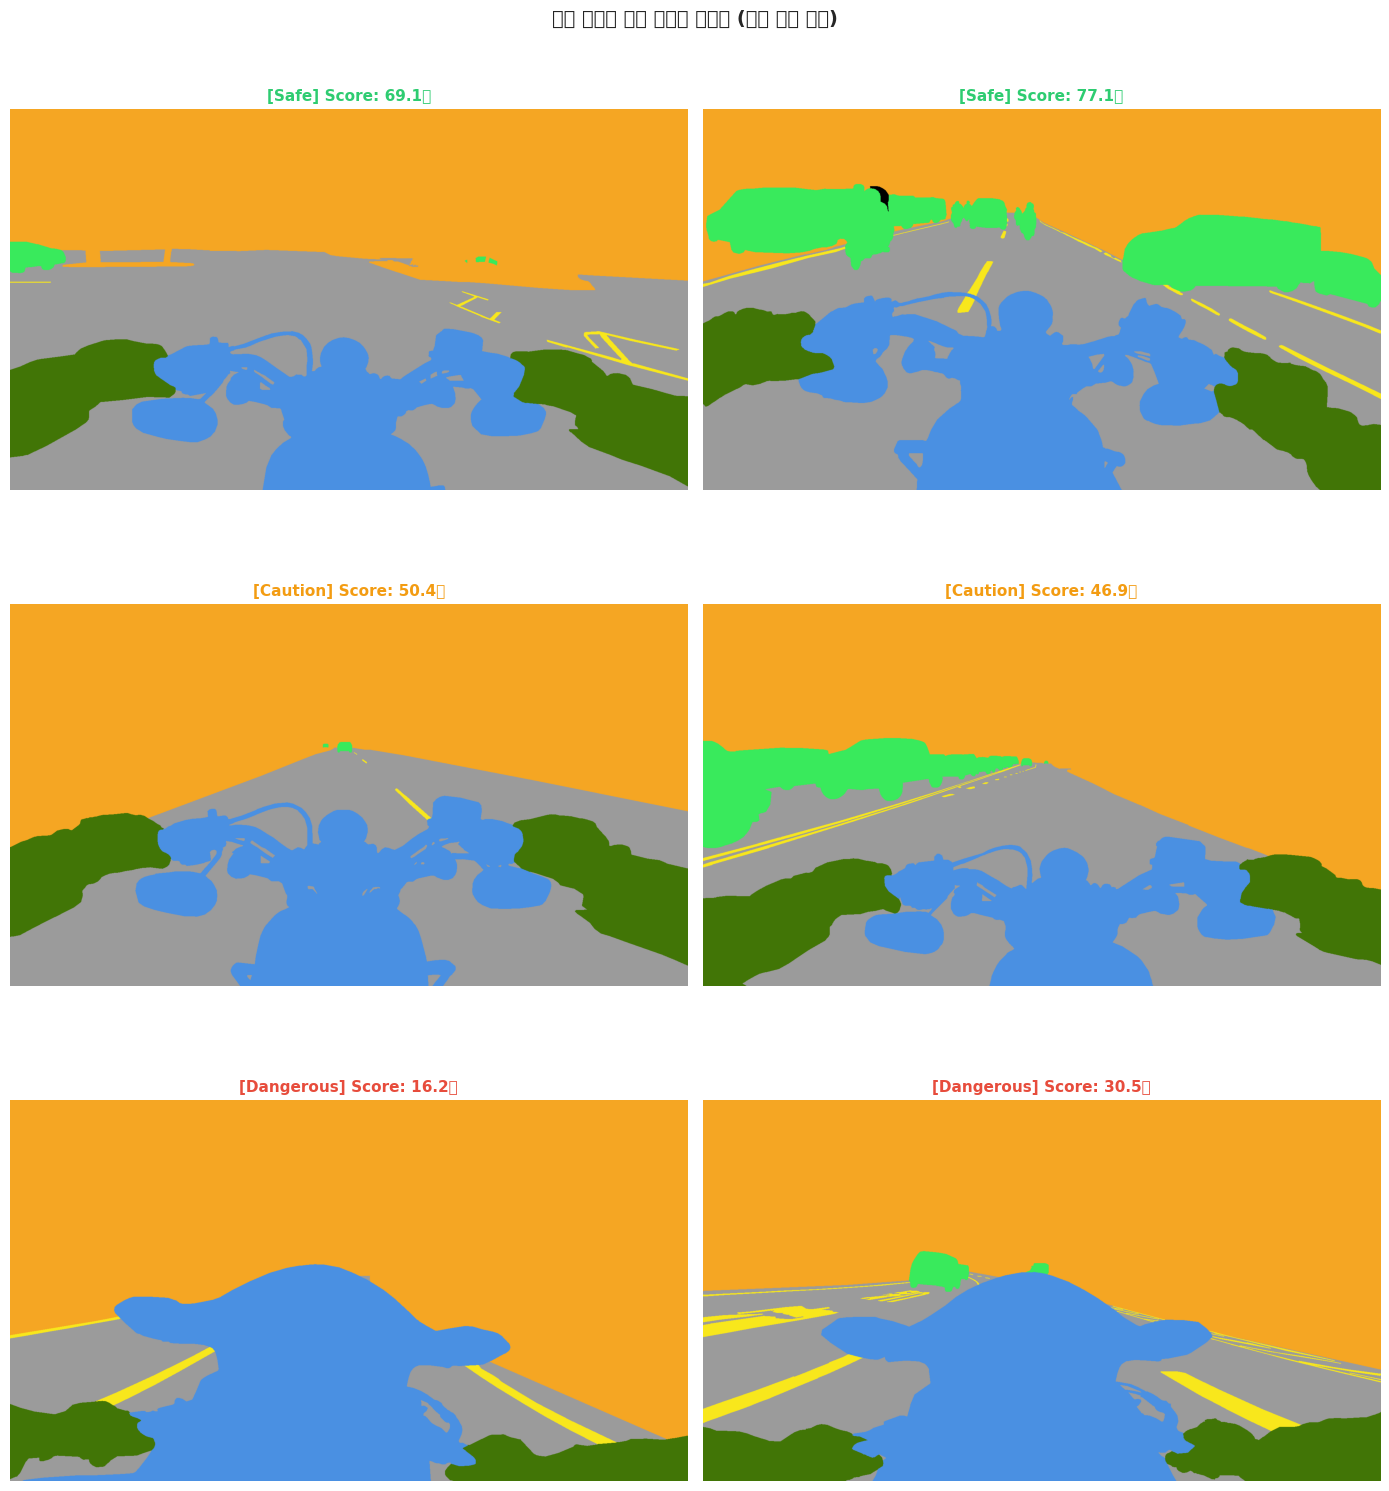


📊 전체 데이터 등급 일치율 (규칙 기반 vs 모델 예측): 100.0%

📊 모델 예측 등급 분포:
pred_grade
Caution      124
Safe          53
Dangerous     23
Name: count, dtype: int64


In [43]:
# ============================================================
# 6-3. 예측 결과 시각화 (대표 프레임)
# ============================================================
# 최적 모델로 전체 데이터 예측
all_pred = best_model.predict(X_adv)
feature_df_adv['pred_grade'] = le.inverse_transform(all_pred)

# 등급별 2장씩 샘플
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
grade_order = ['Safe', 'Caution', 'Dangerous']
grade_colors = {'Safe': '#2ecc71', 'Caution': '#f39c12', 'Dangerous': '#e74c3c'}

for gi, grade in enumerate(grade_order):
    subset = feature_df_adv[feature_df_adv['pred_grade'] == grade]
    n_samples = min(2, len(subset))
    if n_samples == 0:
        continue
    samples = subset.sample(n=n_samples, random_state=42)

    for si, (_, row) in enumerate(samples.iterrows()):
        fname = row['file_name']
        fuse_path = IMAGE_DIR + '/' + (fname + '___fuse.png')
        orig_path = IMAGE_DIR + '/' + fname
        img_path = fuse_path if os.path.exists(fuse_path) else orig_path
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[gi, si].imshow(img)
        score_val = row['safety_score']
        title = f'[{grade}] Score: {score_val}점'
        axes[gi, si].set_title(title, fontsize=11,
                                color=grade_colors[grade], fontweight='bold')
        axes[gi, si].axis('off')

plt.suptitle('안전 등급별 대표 프레임 시각화 (모델 예측 기준)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 등급 일치율
match_rate = (feature_df_adv['safety_grade'] == feature_df_adv['pred_grade']).mean()
print(f'\n📊 전체 데이터 등급 일치율 (규칙 기반 vs 모델 예측): {match_rate:.1%}')

# 등급별 프레임 수
print(f'\n📊 모델 예측 등급 분포:')
print(feature_df_adv['pred_grade'].value_counts())


---
# 7. 결론

## 7-1. 프로젝트 요약
- **데이터**: Motorcycle Night Ride 데이터셋 (약 200장, 6클래스 세만틱 세그멘테이션)
- **목표**: 세그멘테이션 정보를 활용한 프레임별 안전 점수 산출
- **방법**: 규칙 기반 점수 설계 -> ML 모델로 안전 등급 분류 (Safe / Caution / Dangerous)

## 7-2. 주요 발견
1. **Road 비율이 안전 점수에 가장 큰 영향** - 전방 도로가 넓고 명확할수록 안전
2. **Movable(차량/보행자) 비율이 높으면 위험도 증가** - 장애물 존재가 핵심 위험 요소
3. **파생 Feature (road_undrivable_diff, hazard_ratio 등)가 모델 성능 향상에 기여**
4. **Random Forest가 가장 안정적인 성능** - 적은 데이터에서도 강건하고 해석 가능

## 7-3. Metric 선정 및 결과 분석
- **Macro F1-Score**: 3개 안전 등급을 동등하게 중요시하기 위해 주요 metric으로 채택
- **Confusion Matrix**: Dangerous->Safe 오분류(치명적 오류) 최소화 여부 확인
- 데이터가 적으므로 **5-Fold CV**를 활용한 안정적 성능 평가 수행

## 7-4. 한계 및 향후 과제
- **데이터 수 부족 (약 200장)**: 복잡한 딥러닝 모델 적용이 어려움
- **야간 장면만 존재**: 주간/악천후 등 다양한 환경으로 일반화 불가
- **단일 프레임 기준 평가**: 영상의 시간적 연속성(temporal context) 미반영
- **향후 개선 방향**:
  - ROI(관심영역) 기반 분석으로 전방 도로에 더 집중
  - 시계열 모델링 (연속 프레임 간 안전 점수 변화 추적)
  - 더 큰 데이터셋 구축 및 딥러닝 모델 실험
  - 실제 사고/위험 이벤트 라벨과의 대조 검증
